In [1]:
#%config Completer.use_jedi = False
import os
import sys
sys.path.append('..')


from pprint import pprint    
import tensorflow as tf    
from collections import defaultdict
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from tndm.data import DataManager
from tndm import LFADS
from tndm.runtime import Runtime
from typing import Dict, Any
from sklearn.linear_model import Ridge

from plotting import *

In [2]:
# read the data/disk/scratch/cole/Chewie_CO_FF_2016-10-07_pos_M1_spikes/test_data/
spike_data_dir = "Chewie_CO_FF_2016-10-07_pos_M1_spikes/"

data_dir = os.path.join( spike_data_dir )

dataset, settings = DataManager.load_dataset(
    directory=data_dir,
    filename='dataset.h5')

#train
neural_data = dataset['train_data'].astype('float')
behavioural_data = dataset['train_behaviours'].astype('float')

# valid
valid_neural_data = dataset['valid_data'].astype('float')
valid_behavioural_data = dataset['valid_behaviours'].astype('float')

# test
test_neural_data = dataset['test_data'].astype('float')
test_behavioural_data = dataset['test_behaviours'].astype('float')

# get dataset, to train by myself
# with_behaviour = False for lfads
# target = input for reconstruction

In [3]:
(x_train, y_train), (x_val, y_val) = Runtime.clean_datasets(
            train_dataset=(neural_data, behavioural_data), 
            val_dataset=(valid_neural_data, valid_behavioural_data), 
            with_behaviour=False
            )

In [4]:
x_test = test_neural_data
y_test = test_behavioural_data

In [5]:
def print_data_shape(data):
    if data is not None:
        print(data.shape)
    else:
        print("None")

In [6]:
print_data_shape(x_train)
print_data_shape(y_train)
print_data_shape(x_val)
print_data_shape(y_val)
print_data_shape(x_test)
print_data_shape(y_test)

(136, 73, 70)
None
(17, 73, 70)
None
(17, 73, 70)
(17, 73, 2)


# Quantize data first
## the input and last layer will remain ap<16,6> precision

In [7]:
AP_BITS = 16
AP_INTS = 6

In [44]:
# ususal quantize
from qkeras import QActivation
ACTIVATION_BITS = "quantized_bits({},{},alpha=1)".format(AP_BITS, AP_INTS-1)

In [8]:
'''
total_data = [x_train, y_train, x_val, y_val, x_test, y_test]

for index, d in enumerate(total_data):
    print("index: ", index)
    if d is None:
        print("None")
    else:                
        print("before quantization min/max: {} / {}".format(d.min(), d.max()))
        q_d = QActivation(ACTIVATION_BITS)(d)
        q_d_numpy = q_d.numpy()
        print("after quantization min/max: {} / {}".format(q_d_numpy.min(), q_d_numpy.max()))
        total_data[index] = q_d_numpy
    
[x_train, y_train, x_val, y_val, x_test, y_test] = total_data    
'''

'\ntotal_data = [x_train, y_train, x_val, y_val, x_test, y_test]\n\nfor index, d in enumerate(total_data):\n    print("index: ", index)\n    if d is None:\n        print("None")\n    else:                \n        print("before quantization min/max: {} / {}".format(d.min(), d.max()))\n        q_d = QActivation(ACTIVATION_BITS)(d)\n        q_d_numpy = q_d.numpy()\n        print("after quantization min/max: {} / {}".format(q_d_numpy.min(), q_d_numpy.max()))\n        total_data[index] = q_d_numpy\n    \n[x_train, y_train, x_val, y_val, x_test, y_test] = total_data    \n'

# model parameters

In [9]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
#initial_neural_weight = 1.0 # weight of neural nll
#initial_behaviour_weight = .2 # weight of behaviour loss
#lambda_q = 100.0
#update_rate = .0005
dropout = .15
#seed = 0
#GRU_pre_activation = False
#var_min = 0.0001
#prior_variance = 1
threshold_poisson_log_firing_rate = 100.


layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

In [10]:
pprint(layers_settings)

defaultdict(<function <lambda> at 0x000002138E86AC10>,
            {'decoder': {'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling object at 0x000002138E876EE0>,
                         'kernel_regularizer': <keras.regularizers.L2 object at 0x000002138E876E50>,
                         'original_cell': False,
                         'recurrent_regularizer': <keras.regularizers.L2 object at 0x000002138E876730>}})


In [11]:
layers_settings['encoder']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x213cc4f3b20>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x213cc4f3070>}

In [12]:
layers_settings['decoder']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x2138e876ee0>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x2138e876e50>,
 'recurrent_regularizer': <keras.regularizers.L2 at 0x2138e876730>,
 'original_cell': False}

In [13]:
layers_settings['dense_mean']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x213cc4f3fa0>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x213cc4f3250>}

# input for decoder GRU
# Assuming inputs are zero and everything comes from the GRU

In [25]:
decoder_dim = 64

In [26]:
def get_decoder_input(decoder_dim=64):
    inputs2decoder_train = tf.stack([tf.zeros_like(x_train)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_val = tf.stack([tf.zeros_like(x_val)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_train = np.array(inputs2decoder_train)
    inputs2decoder_val = np.array(inputs2decoder_val)
    print("inputs2decoder_train shape: ", inputs2decoder_train.shape)
    print("inputs2decoder_val shape: ", inputs2decoder_val.shape)
    return inputs2decoder_train, inputs2decoder_val

In [27]:
inputs2decoder_train, inputs2decoder_val = get_decoder_input(decoder_dim=64)

inputs2decoder_train shape:  (136, 73, 64)
inputs2decoder_val shape:  (17, 73, 64)


# loss: poisson_loglike_loss

In [28]:
timestep = 0.01

def poisson_loglike_loss(y_true, y_pred):    
    # POISSON LOG-LIKELIHOOD
    # clip the y_pred first
    y_pred = tf.clip_by_value(y_pred, 
                                     clip_value_min=-threshold_poisson_log_firing_rate,
                                     clip_value_max=threshold_poisson_log_firing_rate
                             )
    targets = tf.cast(y_true, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(timestep) + y_pred, tf.float32)  # Timestep
    npll = tf.nn.log_poisson_loss(
        targets=targets,
        log_input=logrates, compute_full_loss=True
    )
    #print(npll.shape)
    loss = tf.reduce_sum(npll, axis=[1, 2]) # sum up each batch seperately
    loss = tf.reduce_mean(loss) # batch mean
    #loss = tf.reduce_sum()
    return loss

In [37]:
def evaluate_NPLL(targets, pred_logrates):
    targets = tf.cast(targets, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(0.01) + pred_logrates, tf.float32)  # Timestep
    npll = tf.nn.log_poisson_loss(targets=targets,log_input=logrates, compute_full_loss=True)
    results = tf.reduce_sum(npll, axis=[1, 2]) # sum up each batch seperately
    results = tf.reduce_mean(results) # batch mean

    print(results) # negative possion loglikelihood
    return results

In [30]:
#evaluate_NPLL(targets=x_val, pred_logrates=pred_val_logf)

# save quantized weights

In [31]:
def quantize_domain_lfads(model):
    model_save_quantized_weights(model)
    
    # quantize biderectional grus by scratch
    bidirectional_layer = model.get_layer('Encoder_BidirectionalGRU')

    forward_layer = bidirectional_layer.forward_layer
    backward_layer = bidirectional_layer.backward_layer
    
    # forward GRU
    print("quantize forward GRU")
    qs = forward_layer.get_quantizers()[:-1] # final is state quantizer
    ws = forward_layer.get_weights()
    ## pass through qunaitzer
    weights=[]
    for i, (quantizer, weight) in enumerate(zip(qs, ws)):
        #print(i)
        #print(quantizer)
        if quantizer:
            #print(weight)
            weight = tf.constant(weight)
            weight = tf.keras.backend.eval(quantizer(weight))
            print(weight)
            weights.append(weight)
    model.get_layer('Encoder_BidirectionalGRU').forward_layer.set_weights(weights)
    
    # backward GRU
    print("quantize backward GRU")
    qs = backward_layer.get_quantizers()[:-1] # final is state quantizer
    ws = backward_layer.get_weights()
    ## pass through qunaitzer
    weights=[]
    for i, (quantizer, weight) in enumerate(zip(qs, ws)):
        #print(i)
        #print(quantizer)
        if quantizer:
            #print(weight)
            weight = tf.constant(weight)
            weight = tf.keras.backend.eval(quantizer(weight))
            print(weight)
            weights.append(weight)
    model.get_layer('Encoder_BidirectionalGRU').backward_layer.set_weights(weights)
    
    return model

# load pretrained qmodel

In [41]:
from tensorflow.keras import Model

In [32]:
from qkeras.utils import load_qmodel, model_save_quantized_weights

In [33]:
total = list(range(4,16+2,2))

In [34]:
total

[4, 6, 8, 10, 12, 14, 16]

In [48]:
npll_list = []
for tot in total:
    print(f"quantizing {tot}bits model")
    model = load_qmodel(f"lfadsgd{tot}_2.h5",compile=False)
    #model.summary()
    #model.weights
    q_model = quantize_domain_lfads(model)
    #q_model.weights
    # add final quantizer with ap<16,6>
    qact_logf_out = QActivation(ACTIVATION_BITS, name="qact_logf_out")
    q_out =  qact_logf_out(q_model.output)
    q_model = Model(q_model.inputs, q_out)
    q_model.summary()
    q_model.save(f"lfad{tot}bitssgd_qweights.h5")

    print()

quantizing 4bits model
[22:56:22.603] INFO [root.safe_eval:134] keras dict linear
[22:56:22.610] INFO [root.safe_eval:134] keras dict linear
[22:56:22.612] INFO [root.safe_eval:134] keras dict linear
[22:56:23.216] INFO [root.safe_eval:134] keras dict linear
[22:56:23.221] INFO [root.safe_eval:134] keras dict linear
[22:56:23.224] INFO [root.safe_eval:134] keras dict linear
... quantizing model
  Encoder_BidirectionalGRU has not been quantized
quantize forward GRU
[[-0.125 -0.125 -0.125 ... -0.125  0.125  0.25 ]
 [-0.125 -0.125  0.25  ...  0.     0.    -0.125]
 [ 0.    -0.125 -0.125 ...  0.    -0.125  0.   ]
 ...
 [ 0.125  0.125  0.    ... -0.125  0.125 -0.125]
 [ 0.    -0.125 -0.125 ...  0.    -0.125  0.125]
 [ 0.125  0.25   0.    ... -0.125 -0.125 -0.125]]
[[-0.125  0.     0.125 ... -0.125  0.     0.   ]
 [ 0.     0.    -0.125 ...  0.     0.    -0.125]
 [ 0.     0.     0.125 ...  0.     0.     0.   ]
 ...
 [ 0.     0.    -0.125 ...  0.     0.125 -0.125]
 [-0.125 -0.125  0.    ...  0.

 )                                                                                                
                                                                                                  
 postdecoder_dropout (Dropout)  (None, 73, 64)       0           ['q_act_postdecoder[0][0]']      
                                                                                                  
 dense_factor (QDense)          (None, 73, 4)        256         ['postdecoder_dropout[0][0]']    
                                                                                                  
 q_act3_postfactor (QActivation  (None, 73, 4)       0           ['dense_factor[0][0]']           
 )                                                                                                
                                                                                                  
 nerual_dense (QDense)          (None, 73, 70)       350         ['q_act3_postfactor[0][0]']      
          

__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_1[0][0]']                
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 q_act_pos

__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_1[0][0]']                
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 active_bi

__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_1[0][0]']                
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 q_act_pos

__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_1[0][0]']                
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 q_act_pos

__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_1[0][0]']                
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 q_act_pos

__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 70)]     0           []                               
                                                                                                  
 q_act_input (QActivation)      (None, 73, 70)       0           ['input_1[0][0]']                
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['q_act_input[0][0]']            
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
          

In [40]:
npll_list

[<tf.Tensor: shape=(), dtype=float32, numpy=1827.6735>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1813.5359>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1780.9541>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1767.9225>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1766.1182>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1766.3108>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1767.2479>]

# Evaluation

In [48]:
# for plotting
d_all = np.concatenate((dataset['train_target_direction'], dataset['test_target_direction'], dataset['valid_target_direction']))
d = dataset['train_target_direction']
direction_index_train = np.array([sorted(set(d_all)).index(i) for i in d])
d = dataset['test_target_direction']
direction_index_test = np.array([sorted(set(d_all)).index(i) for i in d])
direction_index_all = np.concatenate((direction_index_test, direction_index_train))

In [40]:
from tensorflow.keras import Model

In [ ]:
model_in, decode_in = model.inputs

In [43]:
latent_model = Model(model.inputs[0], model.get_layer('q_act_postdense_latent').output)

In [44]:
latent_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 73, 70)]          0         
                                                                 
 initial_dropout (Dropout)   (None, 73, 70)            0         
                                                                 
 Encoder_BidirectionalGRU (B  [(None, 128),            52224     
 idirectional)                (None, 64),                        
                              (None, 64)]                        
                                                                 
 q_act_postencoder (QActivat  (None, 128)              0         
 ion)                                                            
                                                                 
 postencoder_dropout (Dropou  (None, 128)              0         
 t)                                                        

In [46]:
mean =  latent_model.predict(x_train.astype('float'))

Text(0.5, 1.0, 'Factors')

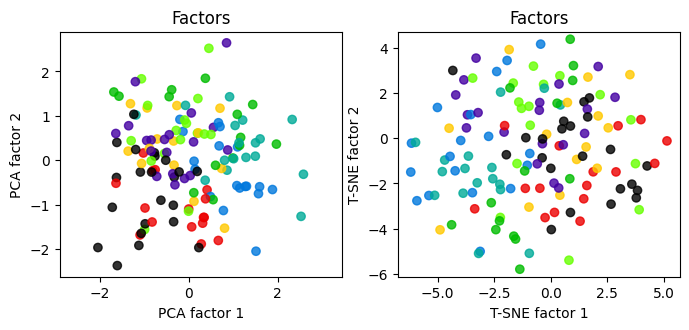

In [49]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(mean)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('T-SNE factor 1')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


# factors

In [ ]:
# latent factors
plt.figure(figsize=(6,6))
plot_all_2factors(z, direction_index_train)
plt.figure(figsize=(8,1.5))
plot_all_1factors(z, direction_index_train)


In [ ]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

In [ ]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train, num=20)

In [ ]:
Xt = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
yt = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

## Test data

In [ ]:
log_f_t, (g0_t, mean_t, logvar_t), z_t = \
    model(test_neural_data.astype('float'), training=False)

In [ ]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


In [ ]:
# relevant factors
plt.figure(figsize=(6,6))
plot_all_2factors(z_t, direction_index_test)
# relevant factors
plt.figure(figsize=(8,1.5))
plot_all_1factors(z_t, direction_index_test)


In [ ]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = np.transpose(z_t.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit[:,test_behavioural_data.shape[1]:]

In [ ]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)
# plot_behaviour(b, behavioural_data, direction_index_train)

In [ ]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

# Trial-averaged firing rates and predictions
Computed from test+train data for better averages

In [ ]:
from sklearn.metrics import mean_squared_error
fig = plt.figure(figsize=(16,10))
colors = plt.cm.nipy_spectral(np.arange(8)/8)
a = []
for i in range(8):
    data = np.vstack((test_neural_data, neural_data))[direction_index_all==i,:,:]

    for i_n,n in enumerate(range(0,70)):
        ax = fig.add_subplot(8, 70, i*70+i_n+1)
        pred = np.vstack((np.exp(log_f_t)*settings['step'], np.exp(log_f)*settings['step']))[np.array(direction_index_all)==i,:,n]
        x = np.arange(data.shape[1])
        ax.plot(x,np.mean(data,axis=0)[:,n],'k',alpha=0.5);
        data_mean = np.mean(data,axis=0)
        data_mean_test = np.mean(data,axis=0)[:,n]
#         print("n",n)
#         print(pred.shape)
#         print(data_mean_test.shape)
        
        ax.fill_between(x,np.mean(data,axis=0)[:,n]-np.std(data,axis=0)[:,n], np.mean(data,axis=0)[:,n]+np.std(data,axis=0)[:,n], alpha=0.2, color='k');
        ax.plot(x,np.mean(pred,axis=0),lw=3, color=colors[i]);
        pred_test = np.mean(pred,axis=0)
#         print(pred_test.shape)

        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim(0,1.5)
        
        data4mse = data_mean_test
        pred4mse = pred_test
        diff = mean_squared_error(data4mse,pred4mse)
        a.append(diff)
        


In [ ]:
print(sum(a) / len(a))
print(max(a))
print(min(a))
print(log_f.shape)

In [ ]:
d_all = dataset['test_target_direction']

d = dataset['test_target_direction']
direction_index_test = np.array([sorted(set(d_all)).index(i) for i in d])
direction_index_all =direction_index_test
print(direction_index_all.shape)